In [331]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
import pickle
import csv
np.random.seed(42)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Importing my already scaled data and importing my scaler

In [332]:
X_train_sc = pd.read_csv('../data/X_train_sc.csv')
X_test_sc = pd.read_csv('../data/X_test_sc.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')
df = pd.read_csv('../data/clean_data.csv')
X = pd.read_csv('../data/X.csv')
with open('../assets/scaler.pkl', 'rb') as f:
    ss = pickle.load(f)

# Instantiaing  and fitting my model

In [333]:
X_train_sc.shape

(1537, 160)

In [334]:
lasso = LassoCV(n_alphas = 500)
lasso.fit(X_train_sc, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=500, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

# Scoring my model on train and test data

In [335]:
lasso.score(X_train_sc, y_train)

0.874046314408585

In [336]:
lasso.score(X_test_sc, y_test)

0.9104308913219593

# Calculating RMSE for train and test data

In [337]:
y_hat_train = lasso.predict(X_train_sc)
y_hat_test = lasso.predict(X_test_sc)

In [338]:
mean_squared_error(y_train, y_hat_train) ** .5

28232.948516747936

In [339]:
mean_squared_error(y_test, y_hat_test) ** .5

23464.63510165118

In [340]:
lasso.intercept_

181064.58914507335

# Saving model and loading my columns

In [341]:
with open('../assets/columns.pkl', 'rb') as f:
    columns = pickle.load(f)

In [342]:
with open('../assets/lasso.pkl', 'wb+') as f:
    pickle.dump(lasso, f)

# Creating a dataframe of coefficients to see their weight

In [343]:
coef = pd.DataFrame(lasso.coef_, index = columns, columns=['weight'])
coef.sort_values(by='weight', ascending=False).head(10)

,weight
Gr Liv Area,18862.143971
Overall Qual,17585.303142
Garage Cars_3.0,8463.868246
Kitchen Qual_Ex,7701.298756
Year Built,6703.378189
Bsmt Qual_Ex,5374.574867
Bsmt Exposure_Gd,4571.055007
Screen Porch,4289.868107
Bldg Type_1Fam,3595.081791
Neighborhood_NridgHt,3121.776507


In [344]:
coef = pd.DataFrame(lasso.coef_, index = columns, columns=['weight'])
coef.sort_values(by='weight', ascending=True).head(10)

,weight
Misc Val,-4788.848534
Bsmt Full Bath_0.0,-3853.020462
Fireplaces_0,-3170.360673
Exter Qual_TA,-2456.313465
Neighborhood_Edwards,-2350.431874
BsmtFin Type 1_Unf,-2206.535756
Pool Area,-1761.600927
MS Zoning_RM,-1344.349566
Kitchen Qual_TA,-954.050974
Overall Qual_6,-766.250800


# Creating plots based on my model (for presentation)

In [345]:
y = df['SalePrice']

In [346]:
df_new = X[columns]

In [347]:
df_new_fit= ss.transform(df_new)

In [348]:
df_new['predictions'] = lasso.predict(df_new_fit)

In [349]:
df_new['SalePrice'] = y

Text(0,0.5,'Sale Price')

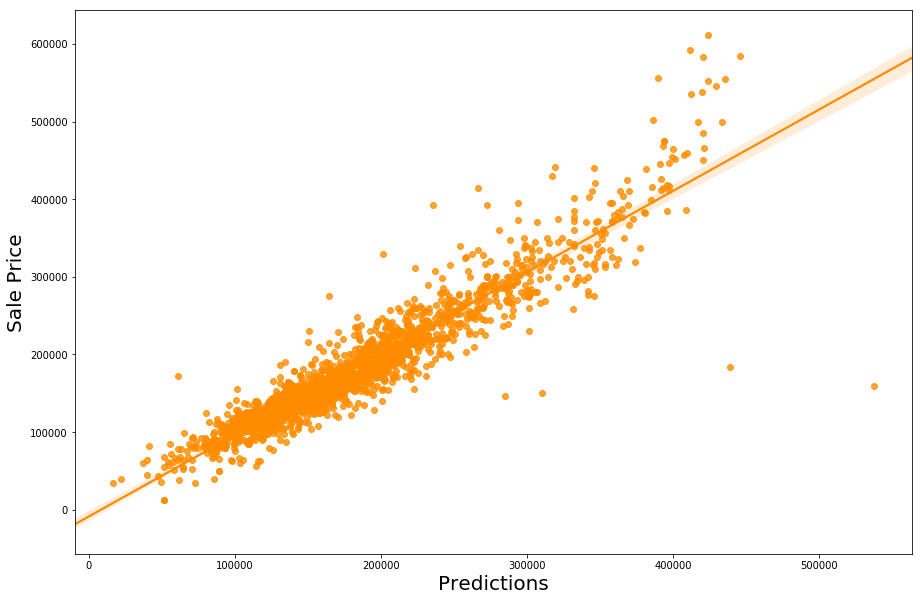

In [350]:
plt.figure(figsize=(15,10))
sns.regplot(x = 'predictions', y = 'SalePrice', data=df_new, color = 'darkorange')
plt.xlabel('Predictions', fontsize=20)
plt.ylabel('Sale Price', fontsize=20)

# Creating a data frame of all coefficients and their absolute value

In [351]:
betas = pd.DataFrame(lasso.coef_, index = columns)

In [352]:
betas.columns = ['weight']

In [353]:
betas['abs_w'] = betas.weight.abs()

In [354]:
betas.head()

,weight,abs_w
PID,-0.000000,0.000000
Lot Frontage,0.000000,0.000000
Lot Area,2434.952918,2434.952918
Overall Qual,17585.303142,17585.303142
Overall Cond,2982.022740,2982.022740


In [355]:
weights = betas.sort_values('abs_w', ascending=False)['weight'].head(20)

In [356]:
labels = weights.index

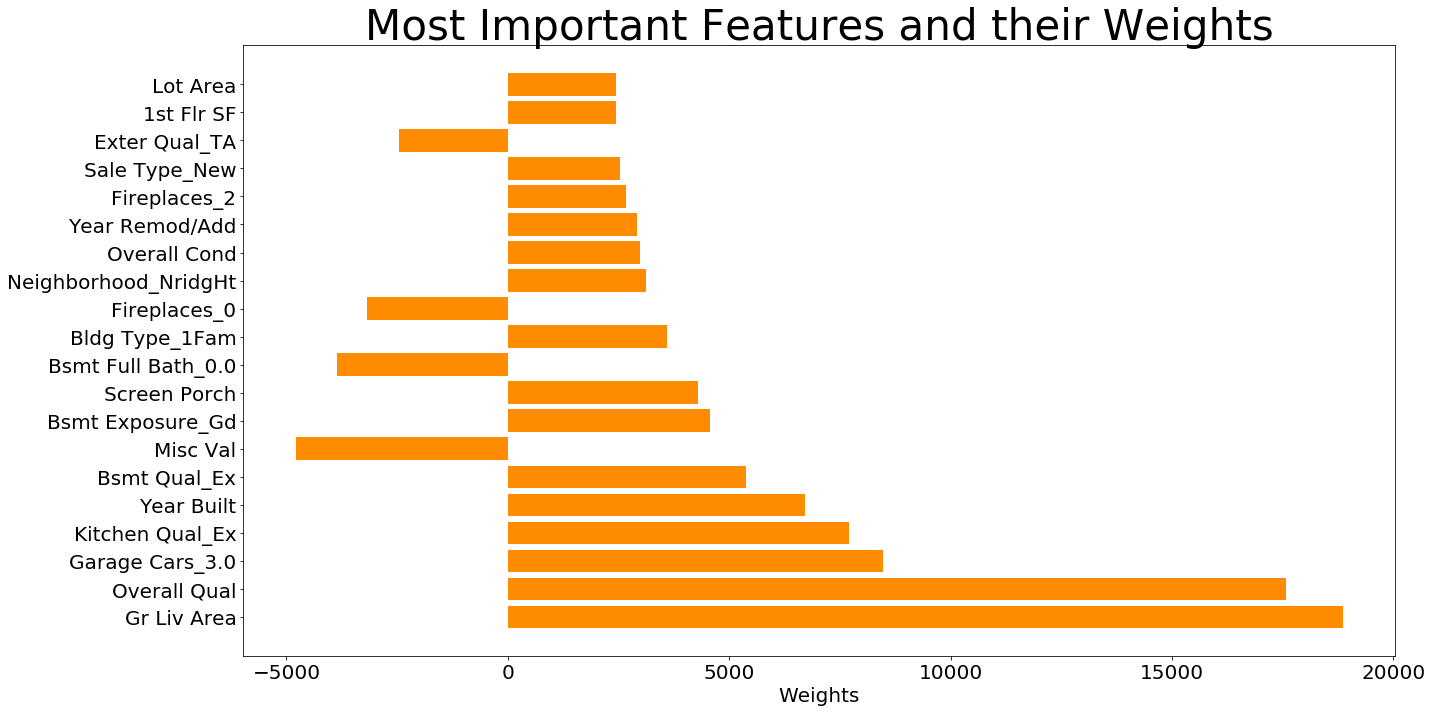

In [357]:
plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = 'darkorange')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=20)
plt.title(f'Most Important Features and their Weights', fontsize=42)
plt.tight_layout()

# Creating line plots to examine specific features and their sales price

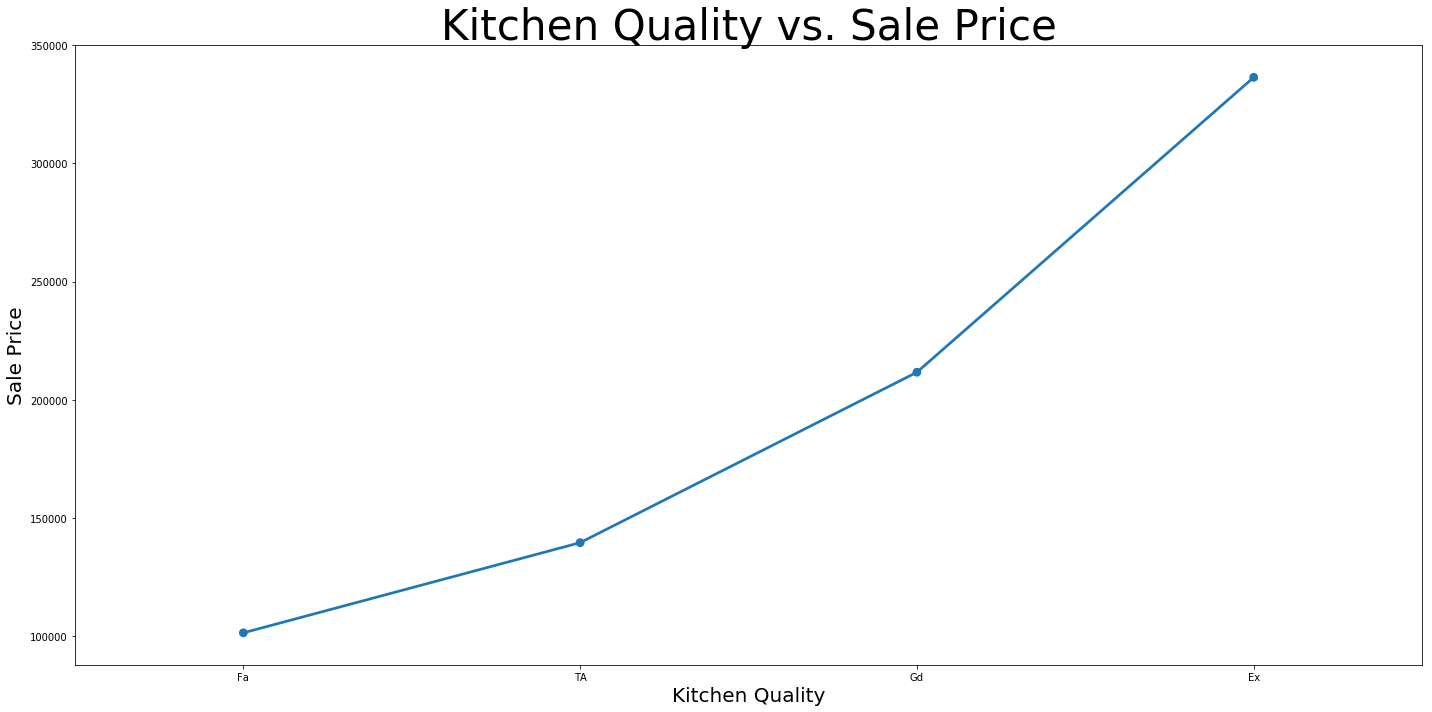

In [358]:
plt.figure(figsize=(20,10))
sns.pointplot(x = 'Kitchen Qual', y = 'SalePrice', data =df, 
              order = ['Fa', 'TA', 'Gd', 'Ex'], 
              orient = 'v', ci = 0)
plt.xlabel('Kitchen Quality',fontsize=20)
plt.ylabel('Sale Price',fontsize=20)
plt.title(f'Kitchen Quality vs. Sale Price', fontsize=42)
plt.tight_layout()

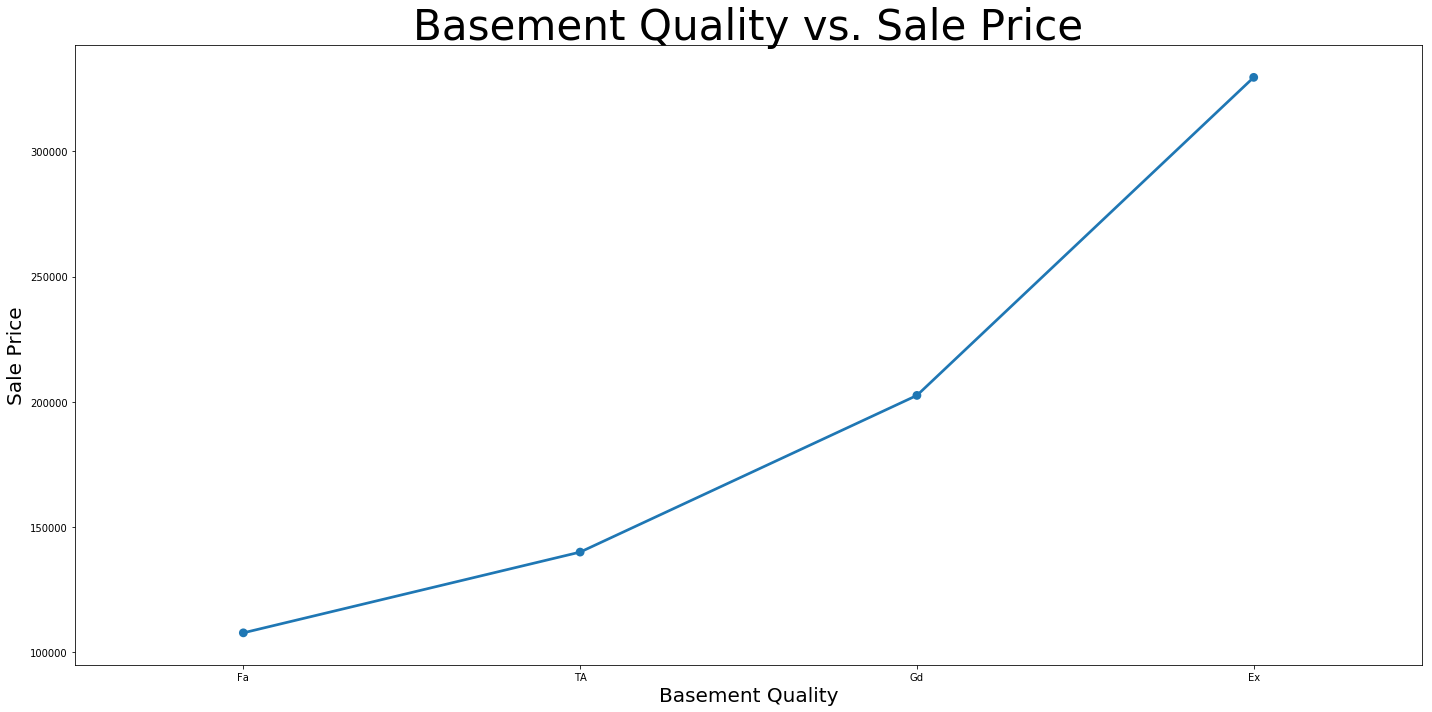

In [359]:
plt.figure(figsize=(20,10))
sns.pointplot(x = 'Bsmt Qual', y = 'SalePrice', data = df, 
              order = ['Fa', 'TA', 'Gd', 'Ex'], 
              orient = 'v', ci = 0)
plt.xlabel('Basement Quality',fontsize=20)
plt.ylabel('Sale Price',fontsize=20)
plt.title(f'Basement Quality vs. Sale Price', fontsize=42)
plt.tight_layout()

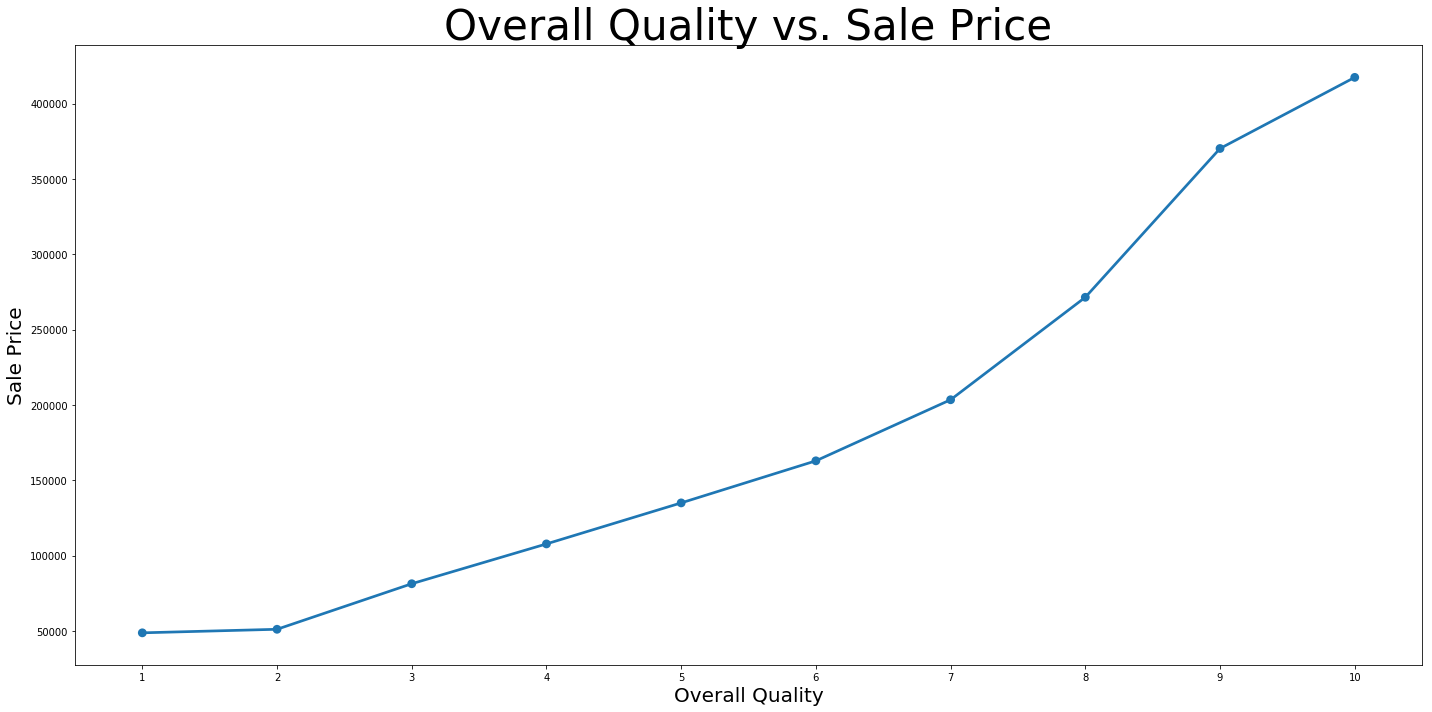

In [360]:
plt.figure(figsize=(20,10))
sns.pointplot(x = 'Overall Qual', y = 'SalePrice', data = df, 
              #order = ['TA', 'Fa', 'Gd', 'Ex'], 
              orient = 'v', ci = 0)
plt.xlabel('Overall Quality',fontsize=20)
plt.ylabel('Sale Price',fontsize=20)
plt.title(f'Overall Quality vs. Sale Price', fontsize=42)
plt.tight_layout()

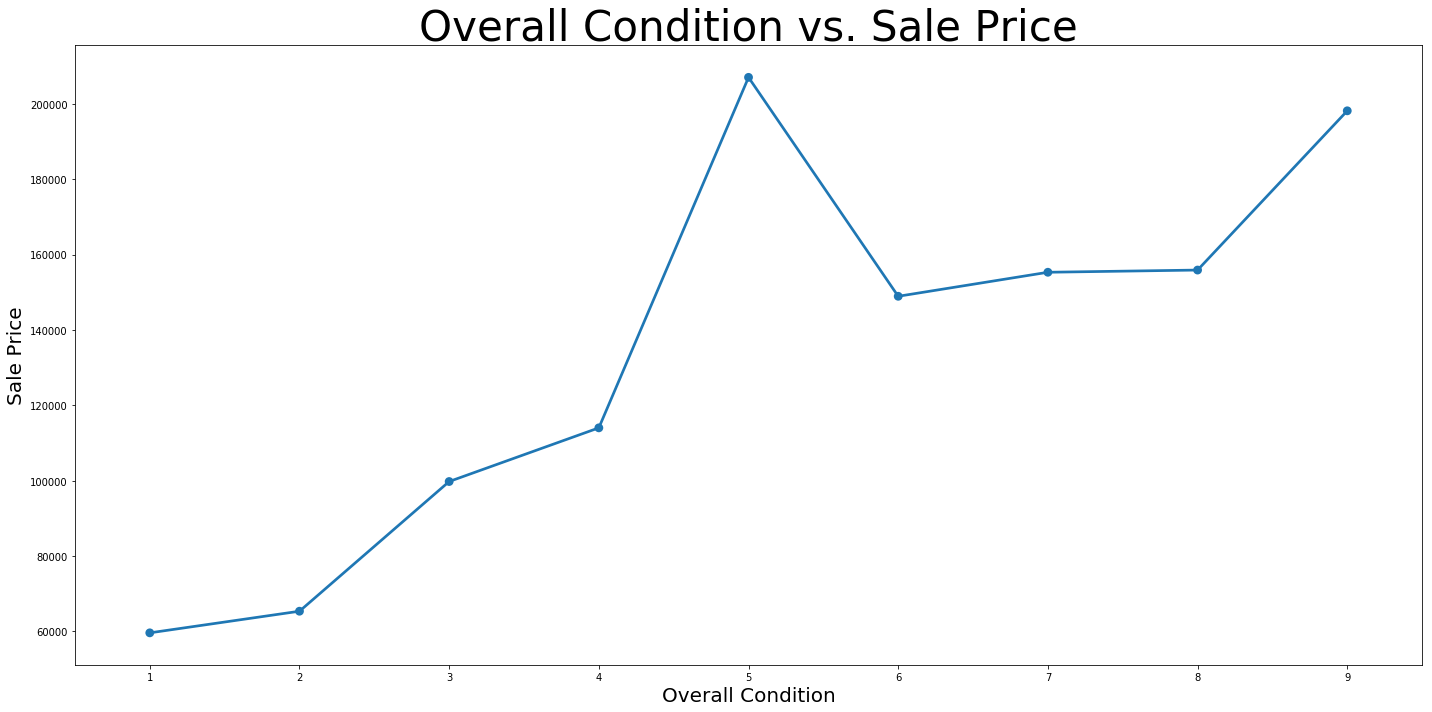

In [361]:
plt.figure(figsize=(20,10))
sns.pointplot(x = 'Overall Cond', y = 'SalePrice', data =df, 
              #order = ['TA', 'Fa', 'Gd', 'Ex'], 
              orient = 'v', ci = 0)
plt.xlabel('Overall Condition',fontsize=20)
plt.ylabel('Sale Price',fontsize=20)
plt.title(f'Overall Condition vs. Sale Price', fontsize=42)
plt.tight_layout()